In [1]:
from pyannote.audio import Pipeline
from env import hugging_face_token
# from pyannote.audio.pipelines import SpeakerDiarization

In [16]:
from IPython.display import Audio, display

In [2]:
import numpy as np
import ffmpeg
import torch, torchaudio

SR = 16_000

def load_audio(file: str, sr: int = SR):
    """
    Open an audio file and read as mono waveform, resampling as necessary

    Parameters
    ----------
    file: str
        The audio file to open

    sr: int
        The sample rate to resample the audio if necessary

    Returns
    -------
    A NumPy array containing the audio waveform, in float32 dtype.
    """
    try:
        # This launches a subprocess to decode audio while down-mixing and resampling as necessary.
        # Requires the ffmpeg CLI and `ffmpeg-python` package to be installed.
        out, _ = (
            ffmpeg.input(file, threads=0)
            .output("-", format="s16le", acodec="pcm_s16le", ac=1, ar=sr)
            .run(cmd=["ffmpeg", "-nostdin"], capture_stdout=True, capture_stderr=True)
        )
    except ffmpeg.Error as e:
        raise RuntimeError(f"Failed to load audio: {e.stderr.decode()}") from e

    return np.frombuffer(out, np.int16).flatten().astype(np.float32) / 32768.0  #Why 32768?

def save_audio(path: str,
               audio,
               sampling_rate: int = 16000):
    if not torch.is_tensor(audio):
        try:
            audio = torch.Tensor(audio)
        except:
            raise TypeError("Audio cannot be casted to tensor. Cast it manually")
    torchaudio.save(path, audio.unsqueeze(0), sampling_rate, bits_per_sample=16)


In [3]:

print('loading pipeline')
pipeline = Pipeline.from_pretrained("pyannote/speaker-diarization",
                                    use_auth_token = hugging_face_token,
                                    )


loading pipeline


The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.
The torchaudio backend is switched to 'soundfile'. Note that 'sox_io' is not supported on Windows.


In [4]:
example_file = '../../data/db short intro.ogg'


In [11]:
print('diarizing')
diarization = pipeline(example_file)
print('diarizing complete')

diarizing
diarizing complete


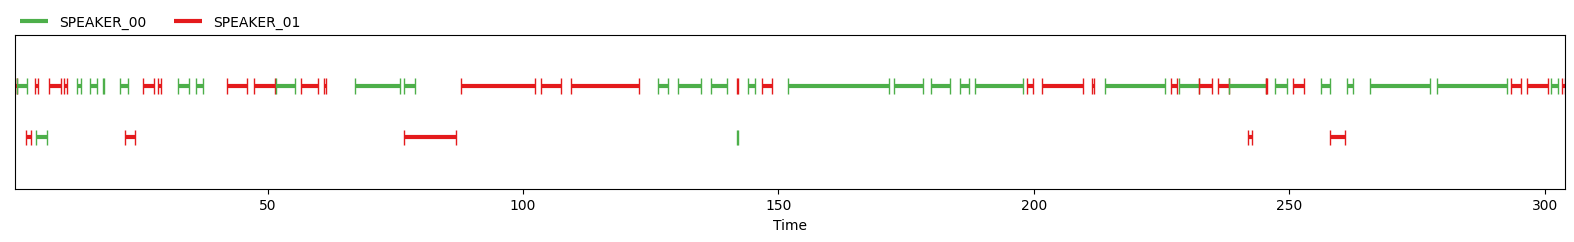

In [12]:
diarization

Feeding it the audio file directly takes a long time (3.5 minutes for a 5 minute sample) gives poor results (only 2 speakers detected).

In [ ]:
waveform = load_audio(example_file)
audio = {"waveform": torch.Tensor(waveform).unsqueeze_(0), "sample_rate": SR}
diarization = pipeline(audio, num_speakers=4)
data = diarization.for_json()['content']
diarization

In [ ]:
# Commented out to prevent notebook size from being too large

# data = [(entry['label'],entry['segment']) for entry in diarization.for_json()['content']]
# for speaker, segment in data:
#     start = int(segment['start'] * SR)
#     end = int(segment['end'] * SR)
#     print(speaker)
#     display(Audio(waveform[start:end], rate=SR))

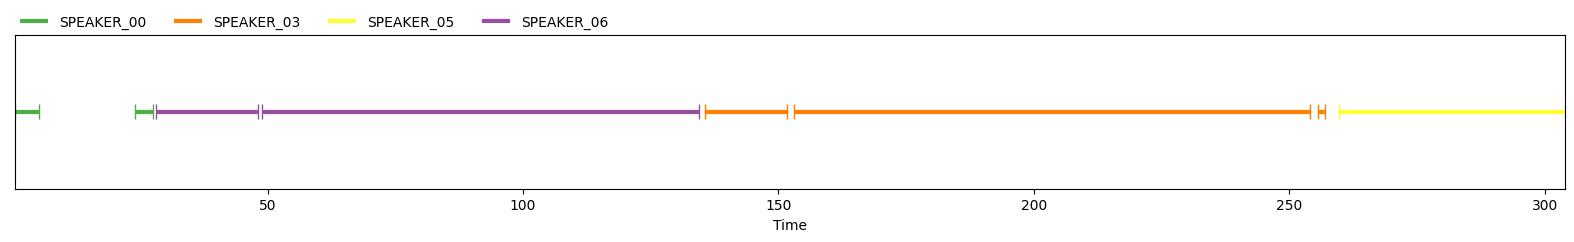

In [20]:
cr_podcast_file = '../000_CR_podcast_44_LibSyn192.mp3'
waveform = load_audio(cr_podcast_file)
audio = {"waveform": torch.Tensor(waveform).unsqueeze_(0), "sample_rate": SR}
diarization = pipeline(audio)
diarization

In [21]:
print(help(diarization))

Help on Annotation in module pyannote.core.annotation object:

class Annotation(builtins.object)
 |  Annotation(uri: Optional[str] = None, modality: Optional[str] = None)
 |  
 |  Annotation
 |  
 |  Parameters
 |  ----------
 |  uri : string, optional
 |      name of annotated resource (e.g. audio or video file)
 |  modality : string, optional
 |      name of annotated modality
 |  
 |  Returns
 |  -------
 |  annotation : Annotation
 |      New annotation
 |  
 |  Methods defined here:
 |  
 |  __bool__(self)
 |      Emptiness
 |      
 |      >>> if annotation:
 |      ...    # annotation is not empty
 |      ... else:
 |      ...    # annotation is empty
 |  
 |  __contains__(self, included: Union[pyannote.core.segment.Segment, pyannote.core.timeline.Timeline])
 |      Inclusion
 |      
 |      Check whether every segment of `included` does exist in annotation.
 |      
 |      Parameters
 |      ----------
 |      included : Segment or Timeline
 |          Segment or timeline bei

In [42]:
# Commented out to prevent notebook size from being too large

# data = [(entry['label'],entry['segment']) for entry in diarization.for_json()['content']]
# for speaker, segment in data:
#     start = int(segment['start'] * SR)
#     end = int(segment['end'] * SR)
#     print(speaker)
#     display(Audio(waveform[start:end], rate=SR))

## Closing thoughts

The diarization pipeline worked very well on the Critical Role mp3 with near-perfect accuracy.  Out of the entire 14 minute file only 3 segments were incorrectly labeled, and each of them were less than 2 seconds long.

However when used on a sample of our own game it performed terribly.  It was actually so inconsistent that I was unable to identify which speaker each label was supposed to correspond to.

If you want to diarize clean professional quality audio of celebrity voices this model might be for you.  But as of right now I don't see a good place for it in my project.

# Troubleshooting Runtime Error

In [8]:
import torch.cuda as tc

tc.is_available(), tc.device_count(), tc.current_device(), tc.get_device_name(0)

(True, 1, 0, 'NVIDIA GeForce GTX 1060 6GB')